In [ ]:
%capture --no-stderr
! pip install langsmith langchain-community langchain chromadb tiktoken openai langchainhub

# Use Case Tutorial: RAG

We will walk through the evaluation workflow for RAG (retrieval augmented generation).

## Overview

We will discuss each piece of the workflow below.

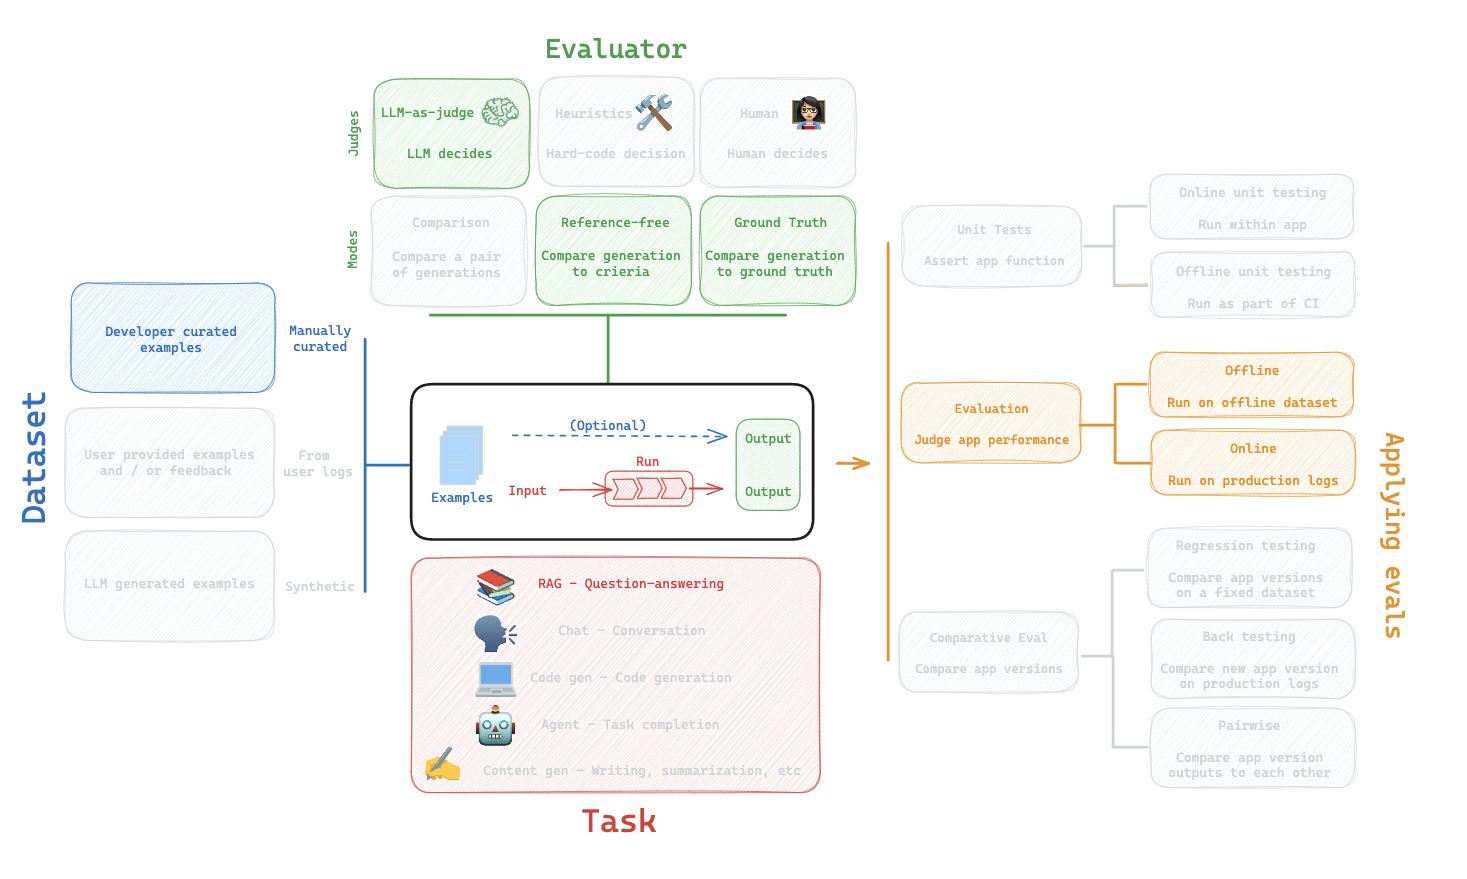

## Dataset

Here is a dataset of [LCEL (LangChain Expression Language)](https://python.langchain.com/v0.1/docs/expression_language/) related questions that we will use.

This dataset was created using csv upload in the LangSmith UI:

https://smith.langchain.com/public/65830565-81b2-4581-859f-c4aabaadf1cc/d

Here, we ensure that API keys for OpenAI as well as LangSmith are set.

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("LANGCHAIN_API_KEY")

In [2]:
### Dataset name
dataset_name = "LCEL-QA"

## Task 

Here is a chain that will perform RAG on [LCEL (LangChain Expression Language)](https://python.langchain.com/v0.1/docs/expression_language/) docs. 

We will be using LangChain strictly for creating the retriever and retrieving the relevant documents. 

The overall pipeline does not use LangChain; LangSmith works regardless of whether or not your pipeline is built with LangChain.

Here, we return the retrieved documents as part of the final answer. 

However, below we will show that this is not required (using evaluation of intermediate steps).

See our [RAG-From-Scratch](https://github.com/langchain-ai/rag-from-scratch) repo and tutorial video series for more on this.

In [3]:
### INDEX

from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load docs
url = "https://python.langchain.com/v0.1/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=4500, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed and store in Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Index
retriever = vectorstore.as_retriever()

In [4]:
### RAG bot 

import openai
from langsmith import traceable
from langsmith.wrappers import wrap_openai

class RagBot:
    
    def __init__(self, retriever, model: str = "gpt-4-0125-preview"):
        self._retriever = retriever
        # Wrapping the client instruments the LLM
        self._client = wrap_openai(openai.Client())
        self._model = model

    @traceable()
    def retrieve_docs(self, question):
        return self._retriever.invoke(question)

    @traceable()
    def invoke_llm(self, question, docs):
        response = self._client.chat.completions.create(
            model=self._model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful AI code assistant with expertise in LCEL."
                    " Use the following docs to produce a concise code solution to the user question.\n\n"
                    f"## Docs\n\n{docs}",
                },
                {"role": "user", "content": question},
            ],
        )

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": response.choices[0].message.content,
            "contexts": [str(doc) for doc in docs],
        }

    @traceable()
    def get_answer(self, question: str):
        docs = self.retrieve_docs(question)
        return self.invoke_llm(question, docs)

rag_bot = RagBot(retriever)

In [8]:
response = rag_bot.get_answer("How to build a RAG chain in LCEL?")
response["answer"][:150]

'Building a RAG (Retrieval-Augmented Generation) chain in LangChain Expression Language (LCEL) allows you to leverage the power of document retrieval t'

Define a function that will:

1) Take a dataset `example`
2) Extract the relevant key (e.g., `question`) from the `example`
3) Pass it to the RAG chain
4) Return the relevant output values from the RAG chain

In [5]:
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["input_question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

## Evaluator

There are at least 4 types of RAG eval that users are typically interested in.

1. **Response <> reference answer**

* `Goal`: Measure "*how similar/correct is the RAG chain answer, relative to a ground-truth answer*"
* `Mode`: Uses ground truth (reference) answer supplied through a dataset
* `Judge`: Use LLM-as-judge to assess answer correctness.

2. **Response <> input**

* `Goal`: Measure "*how well does the generated response address the initial user input*"
* `Mode`: Reference-free, because it will compare the answer to the input question
* `Judge`: Use LLM-as-judge to assess answer relevance, helpfulness, etc.  

3. **Response <> retrieved docs**

* `Goal`: Measure "*to what extent does the generated response agree with the retrieved context*"
* `Mode`: Reference-free, because it will compare the answer to the retrieved context
* `Judge`: Use LLM-as-judge to assess faithfulness, hallucinations, etc.

4. **Retrieved docs <> input**

* `Goal`: Measure "*how good are my retrieved results for this query*"
* `Mode`: Reference-free, because it will compare the question to the retrieved context
* `Judge`: Use LLM-as-judge to assess relevance

![](langsmith_rag_eval.png)

### **Response <> reference answer**

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-vs-reference

Here is the information flow:

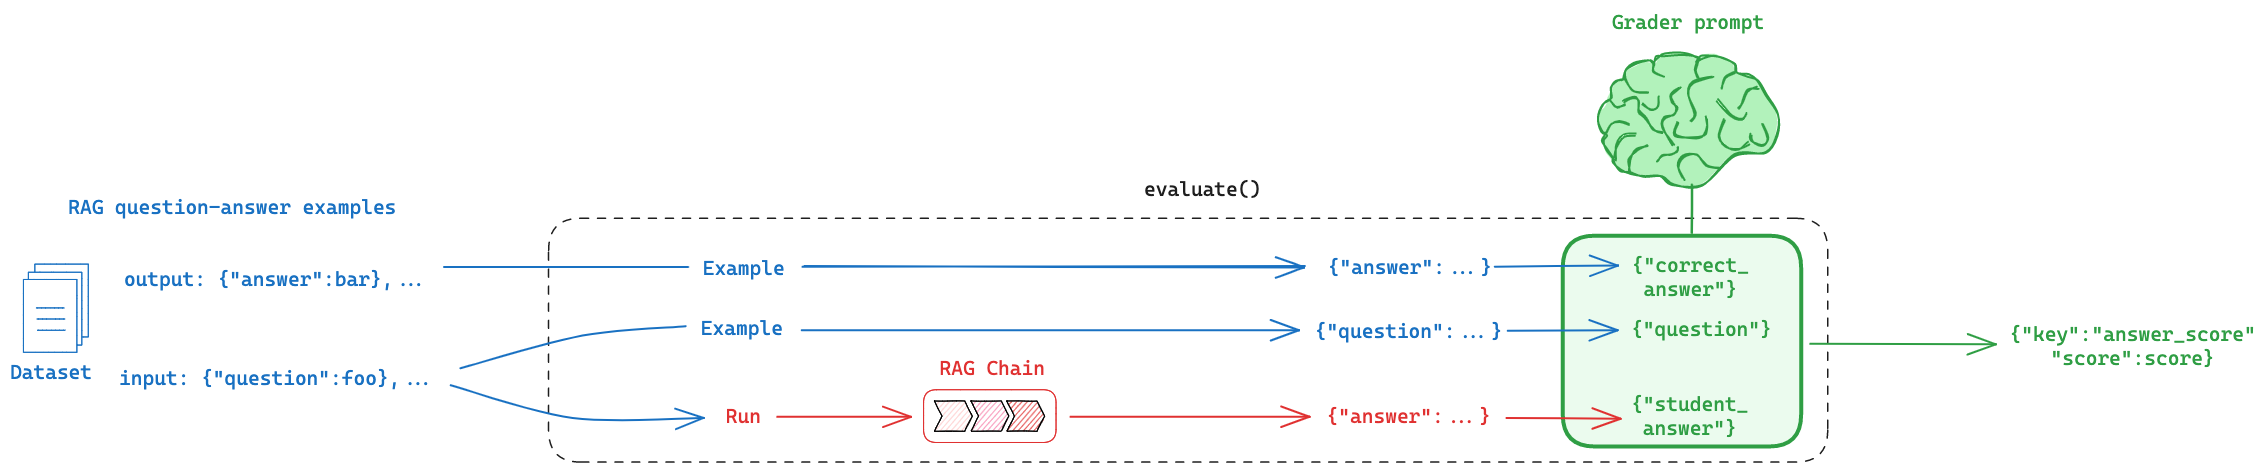

Here is our evaluator function:

* `run` is the invocation of `predict_rag_answer`, which has key `answer`
* `example` is from our eval set, which has keys `input_question` and `output_answer`
* We extract these values and pass them into our grader 

In [6]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt 
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """
    
    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    reference = example.outputs["output_answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

Now, we kick off evaluation: 

* `predict_rag_answer`: Takes an `example` from our eval set, extracts the question, passes to our RAG chain
* `answer_evaluator`: Passes RAG chain answer, question, and ground truth answer to an evaluator 

In [7]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="rag-answer-v-reference",
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)

View the evaluation results for experiment: 'rag-answer-v-reference-552234e6' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/5f34de91-78ab-4ae2-83f3-8f7f93afc998/compare?selectedSessions=03e51c9a-9aeb-4cfe-8f8c-ede797940b9e




0it [00:00, ?it/s]

### **Response <> input**

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-helpfulness

The information flow is similar to above, but we simply look at the `run` answer versus the `example` question.

In [8]:
# Grade prompt 
grade_prompt_answer_helpfulness = prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def answer_helpfulness_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer helpfulness
    """
    
    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input_question"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_helpfulness | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_helpfulness_score", "score": score}

In [9]:
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_helpfulness_evaluator],
    experiment_prefix="rag-answer-helpfulness",
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)

View the evaluation results for experiment: 'rag-answer-helpfulness-e64d4893' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/5f34de91-78ab-4ae2-83f3-8f7f93afc998/compare?selectedSessions=60ee674a-fb59-4c68-86fe-148355fc659e




0it [00:00, ?it/s]

### **Response <> retrieved docs**

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination

Here is the information flow:

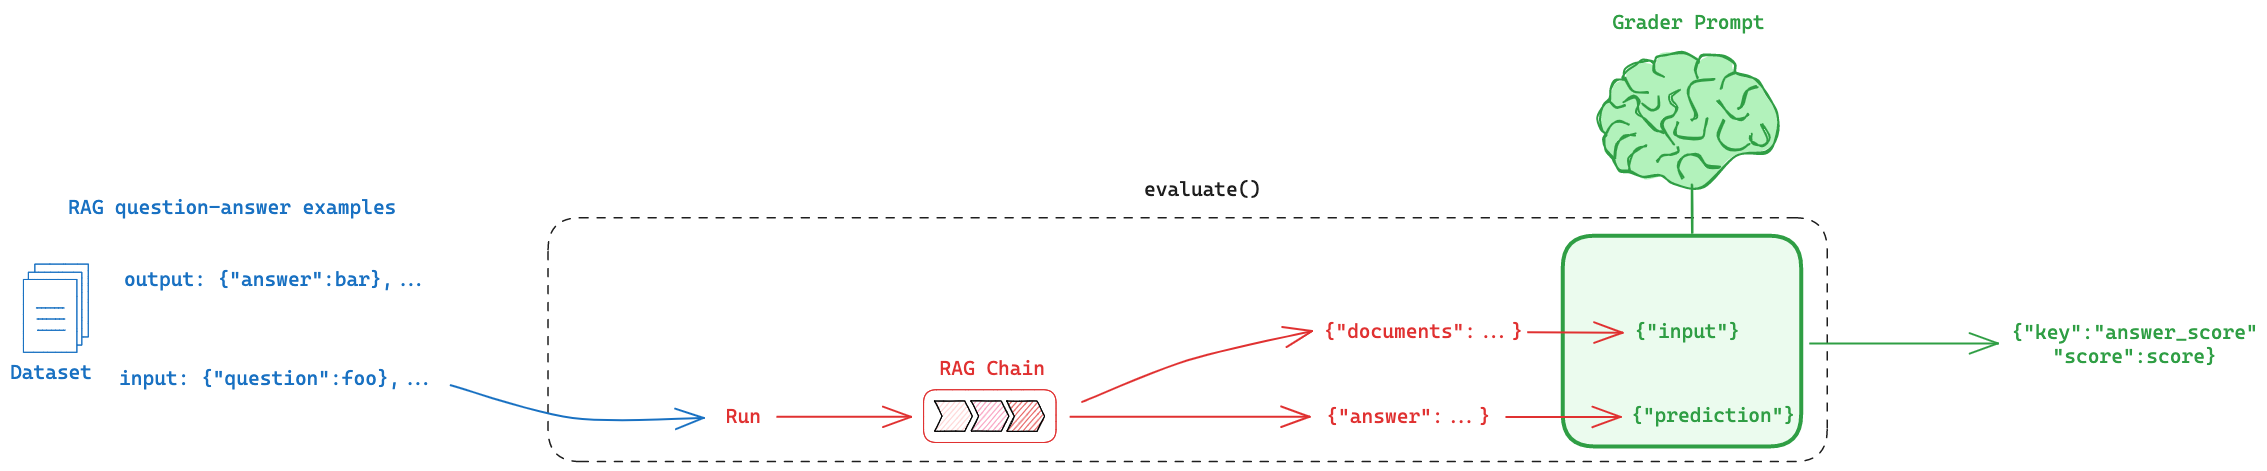

In [10]:
# Prompt 
grade_prompt_hallucinations = prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """
    
    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]
        
    # RAG answer 
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [11]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="rag-answer-hallucination",
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)

View the evaluation results for experiment: 'rag-answer-hallucination-0bcf36cb' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/5f34de91-78ab-4ae2-83f3-8f7f93afc998/compare?selectedSessions=db391b03-d4b2-4c57-9e1c-8ef33389c60d




0it [00:00, ?it/s]

### **Retrieved docs <> input**

Here is an example prompt that we can use:

https://smith.langchain.com/hub/langchain-ai/rag-document-relevance

Here is the information flow:

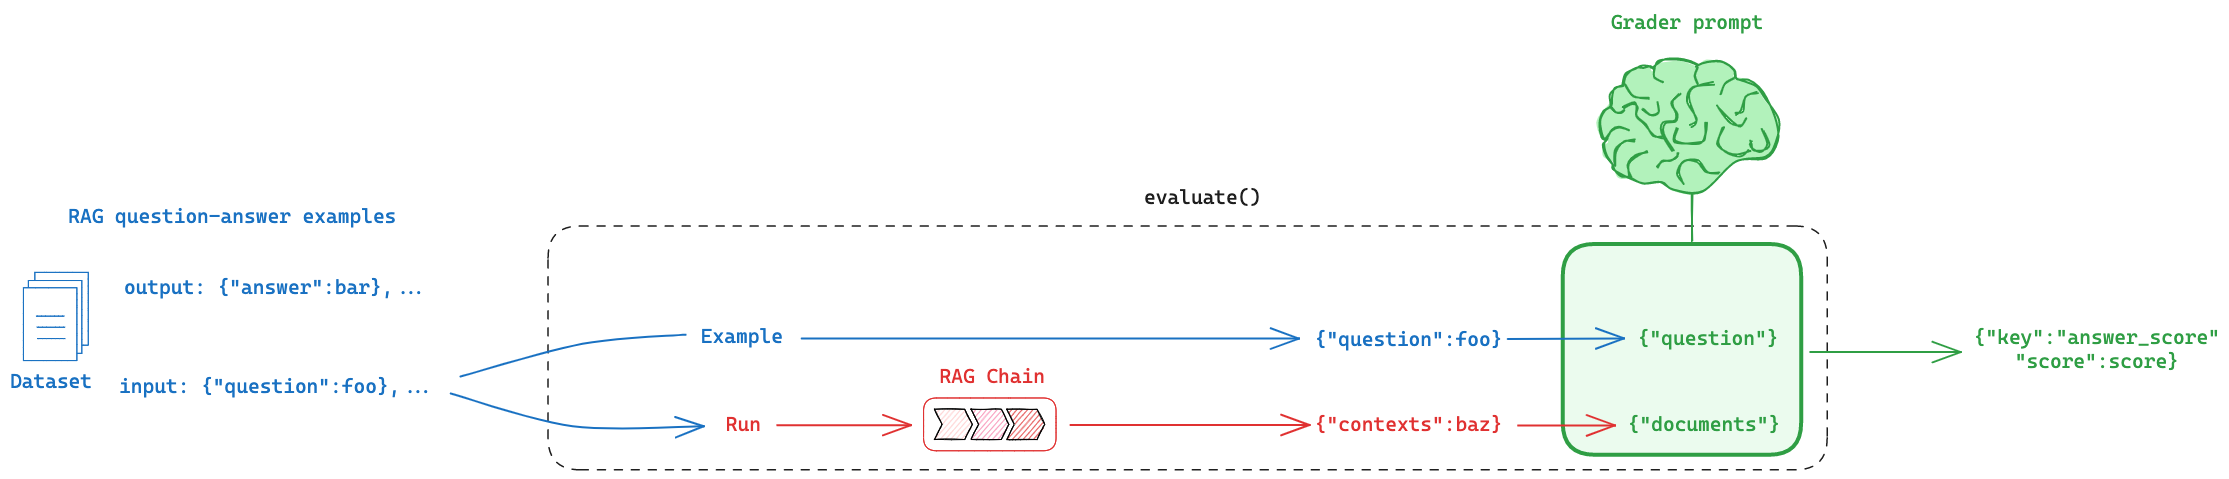

In [15]:
# Grade prompt 
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """
    
    # RAG inputs
    input_question = example.inputs["input_question"]
    contexts = run.outputs["contexts"]
        
    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [16]:
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)

View the evaluation results for experiment: 'rag-doc-relevance-f1df6f71' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/5f34de91-78ab-4ae2-83f3-8f7f93afc998/compare?selectedSessions=8cbe59eb-0e2d-4c1a-9861-fec4fc504402




0it [00:00, ?it/s]

## Evaluating intermediate traces

Above, we returned the retrieved documents as part of the final answer. 

However, we will show that this is not required.

We can isolate them as intermediate chain steps.

See detail on isolating intermediate chain steps [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_on_intermediate_steps).

In [17]:
from langsmith.schemas import Example, Run
from langsmith.evaluation import evaluate

def document_relevance_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see if retrieved documents are relevant to the question
    """

    # Get specific steps in our RAG pipeline, which are noted with @traceable decorator
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])
    input_question = example.inputs["input_question"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}
    
def answer_hallucination_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see the answer is grounded in the documents
    """

    # RAG input
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    contexts = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])

    # RAG output
    prediction = rag_pipeline_run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}
    
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[document_relevance_grader, answer_hallucination_grader],
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)

View the evaluation results for experiment: 'passionate-stomach-89' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/5f34de91-78ab-4ae2-83f3-8f7f93afc998/compare?selectedSessions=72d9c039-84ff-468a-a537-e9a33f8b7e92




0it [00:00, ?it/s]

## Online Evaluation

Three of our evaluators do not require a `reference` (ground truth) answer:

* **Response <> input**
* **Response <> retrieved docs**
* **Retrieved docs <> input**

These simply perform a comparison between run input (question), intermediate steps (documents), and outputs (answer).

This allows us to use then as online evaluators. 

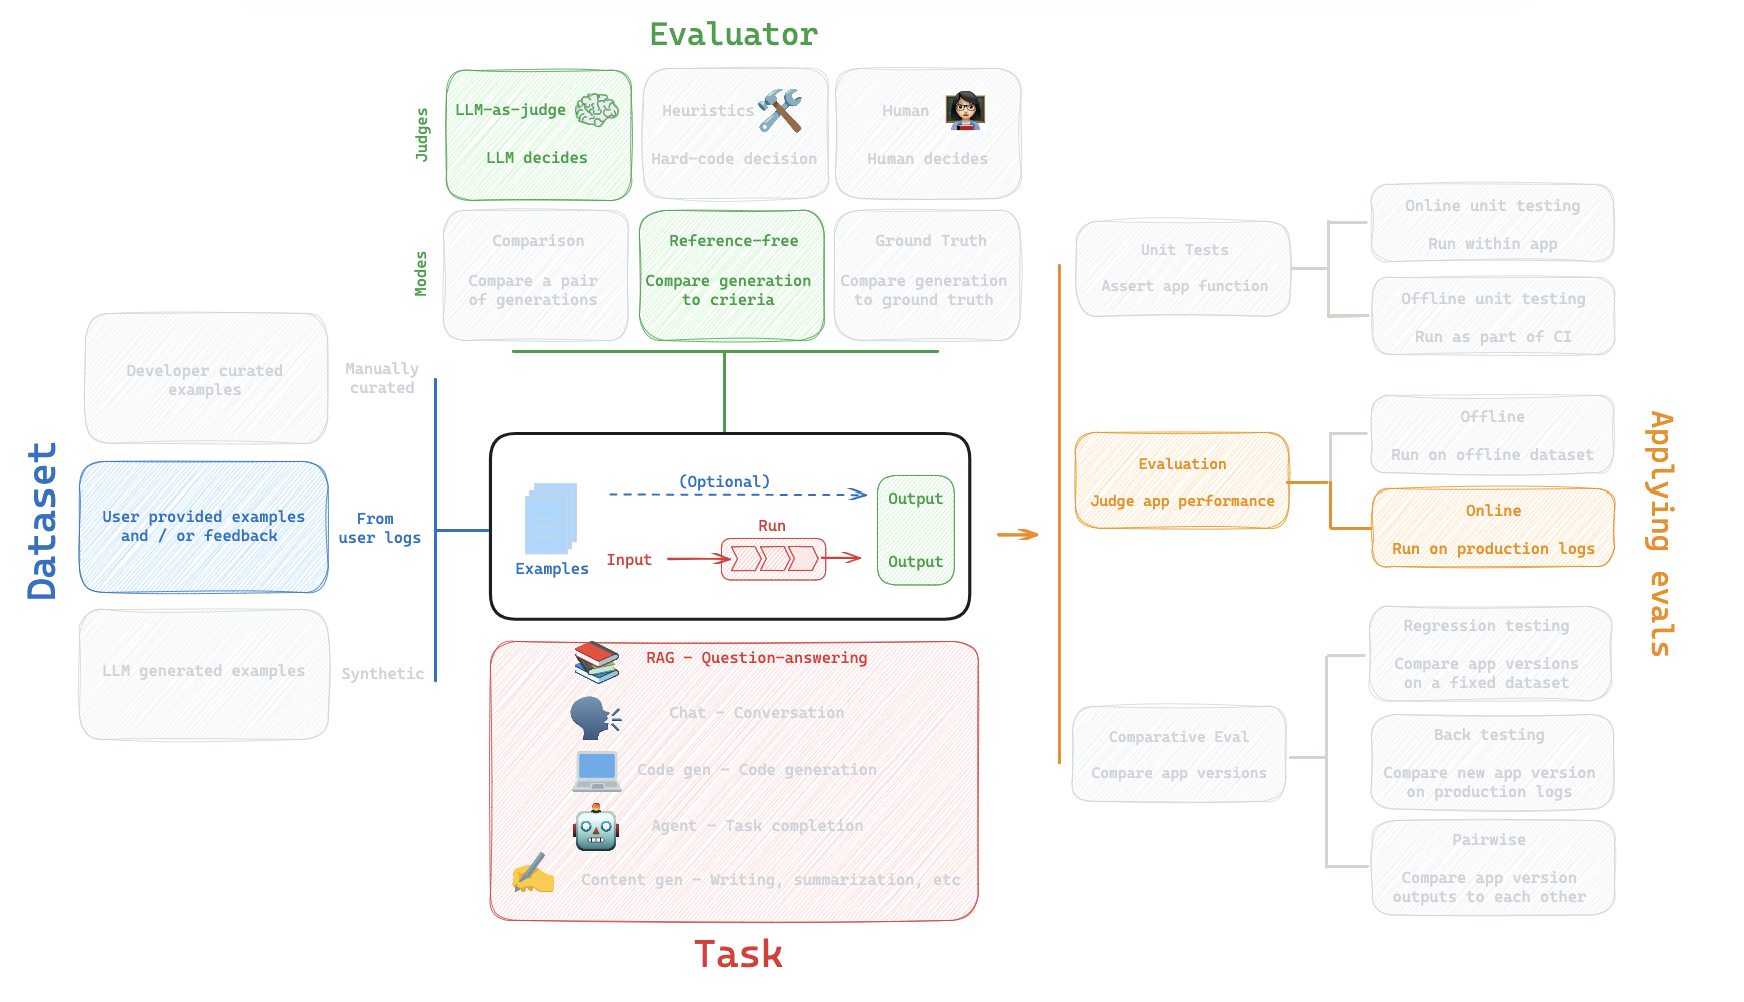

In [13]:
# Project
os.environ["LANGCHAIN_PROJECT"] = "RAG_online_evaluation"

In [14]:
result = rag_bot.get_answer("How do I create a RAG chain?")

In [15]:
result = rag_bot.get_answer("How can I use a runnable lambda?")